<a href="https://colab.research.google.com/github/alexa21342/pong-dqn-ddqn/blob/main/Projectc166f25_02b_dqn_pong.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Alex Cortez
CSCI 166
12/1/2025

 Deep Q-Learning and Double DQN on Atari Pong


# Test 3 --- Final Test for 06.11.2025

In [ ]:
!pip install gymnasium[atari,accept-rom-license]
!pip install autorom
!pip install stable-baselines3

In [ ]:
!AutoROM --accept-license

AutoROM will download the Atari 2600 ROMs.
They will be installed to:
	/usr/local/lib/python3.12/dist-packages/AutoROM/roms

Existing ROMs will be overwritten.


# Install the Gym

In [ ]:
import ale_py
import gymnasium as gym

# Configure the model save drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
save_dir = "/content/drive/MyDrive/PUBLIC/Models"
os.makedirs(save_dir, exist_ok=True)

# Now Model

In [ ]:
from dataclasses import dataclass
import argparse
import time
from datetime import datetime
import numpy as np
import collections
import typing as tt

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.tensorboard.writer import SummaryWriter

## Episode Logger

In [ ]:
# --- Simple episode logger (CSV) ---
import csv, time
from pathlib import Path

RUN_NAME = "baseline_pong"
RUN_DIR = Path("runs") / RUN_NAME
RUN_DIR.mkdir(parents=True, exist_ok=True)

LOG_CSV = RUN_DIR / "training_log.csv"

# Create CSV with header if not exists
if not LOG_CSV.exists():
    with open(LOG_CSV, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["timestamp","global_steps","episode","episode_return","episode_length","epsilon"])

def log_episode(global_steps, episode_idx, ep_return, ep_length, epsilon):
    with open(LOG_CSV, "a", newline="") as f:
        w = csv.writer(f)
        w.writerow([int(time.time()), int(global_steps), int(episode_idx), float(ep_return), int(ep_length), float(epsilon)])


## DQN Model Architecture

In [ ]:
#dqn_model
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
        )
        size = self.conv(torch.zeros(1, *input_shape)).size()[-1]
        self.fc = nn.Sequential(
            nn.Linear(size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )
    def forward(self, x: torch.ByteTensor):
        x = x.float() / 255.0
        return self.fc(self.conv(x))

## Environment Wrappers

In [ ]:
#wrappers

from gymnasium import spaces
from stable_baselines3.common import atari_wrappers


class ImageToPyTorch(gym.ObservationWrapper):
    """
    ImageToPyTorch: Reorders image dimensions from (H, W, C) to (C, H, W)
    for compatibility with PyTorch convolutional layers.
    """
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        obs = self.observation_space
        assert isinstance(obs, gym.spaces.Box)
        assert len(obs.shape) == 3
        new_shape = (obs.shape[-1], obs.shape[0], obs.shape[1])
        self.observation_space = gym.spaces.Box(
            low=obs.low.min(), high=obs.high.max(),
            shape=new_shape, dtype=obs.dtype)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)


class BufferWrapper(gym.ObservationWrapper):
    """
    BufferWrapper: Maintains a rolling window of the last `n_steps` frames
    to give the agent a sense of temporal context.
    """
    def __init__(self, env, n_steps):
        super(BufferWrapper, self).__init__(env)
        obs = env.observation_space
        assert isinstance(obs, spaces.Box)
        new_obs = gym.spaces.Box(
            obs.low.repeat(n_steps, axis=0), obs.high.repeat(n_steps, axis=0),
            dtype=obs.dtype)
        self.observation_space = new_obs
        self.buffer = collections.deque(maxlen=n_steps)

    def reset(self, *, seed: tt.Optional[int] = None, options: tt.Optional[dict[str, tt.Any]] = None):
        for _ in range(self.buffer.maxlen):
            self.buffer.append(np.zeros_like(self.env.observation_space.low))
        obs, extra = self.env.reset()
        return self.observation(obs), extra

    def observation(self, observation: np.ndarray) -> np.ndarray:
        self.buffer.append(observation)
        return np.concatenate(self.buffer)


def make_env(env_name: str, n_steps=4, render_mode=None, **kwargs):
    print(f"Creating environment {env_name}")
    env = gym.make(env_name, render_mode=render_mode, **kwargs)
    env = atari_wrappers.AtariWrapper(env, clip_reward=False, noop_max=0)
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, n_steps=n_steps)
    return env

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## Hyperparameters and Configuration
Below are the main training hyperparameters:
- Learning rate: 1e-4  
- Gamma: 0.99  
- Replay buffer size: 10,000  
- Batch size: 32  
- Target sync: every 500 frames  
- Epsilon decay: 1.0 → 0.01 over ~10k frames  

These values were used consistently for both the baseline DQN and Double DQN.


In [ ]:
# Base Configuration
DEFAULT_ENV_NAME = "ALE/Pong-v5"
MEAN_REWARD_BOUND = 19

GAMMA = 0.99
BATCH_SIZE = 32
REPLAY_SIZE = 10000
LEARNING_RATE = 1e-4
SYNC_TARGET_FRAMES = 1000
REPLAY_START_SIZE = 10000

SAVE_EPSILON = 0.5  # Only save if at least this much better
EPSILON_DECAY_LAST_FRAME = 150000
EPSILON_START = 1.0
EPSILON_FINAL = 0.01

# Tuple of tensors returned from a sampled minibatch in replay buffer
State = np.ndarray
Action = int
BatchTensors = tt.Tuple[
    torch.ByteTensor,           # current state
    torch.LongTensor,           # actions
    torch.Tensor,               # rewards
    torch.BoolTensor,           # done || trunc
    torch.ByteTensor            # next state
]

In [ ]:
# Fast Training Config for Quick Test Run
MEAN_REWARD_BOUND = 5
REPLAY_START_SIZE = 1000
EPSILON_DECAY_LAST_FRAME = 10_000
SYNC_TARGET_FRAMES = 500

# REPLAY_SIZE = 5000  # optional
# BATCH_SIZE = 16     # optional

In [ ]:
import os
from pathlib import Path

# Define directories
save_dir_drive = "/content/drive/MyDrive/PUBLIC/Models"
save_dir_local = "saved_models"

# Create both directories if they don't exist
os.makedirs(save_dir_drive, exist_ok=True)
os.makedirs(save_dir_local, exist_ok=True)

# Safe model filename
env_name = DEFAULT_ENV_NAME
safe_env_name = env_name.replace("/", "_")

## Replay Buffer and Agent Interaction
This section defines:
- The `ExperienceBuffer`, which stores transitions for replay  
- The `Agent` class, which handles action selection using ε-greedy strategy  
- Interaction with the environment (state, action, reward, next state)  

These components form the backbone of the DQN training loop.


In [ ]:
@dataclass
class Experience:
    state: State
    action: Action
    reward: float
    done_trunc: bool
    new_state: State


class ExperienceBuffer:
    def __init__(self, capacity: int):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, experience: Experience):
        self.buffer.append(experience)

    def sample(self, batch_size: int) -> tt.List[Experience]:
        indices = np.random.choice(len(self), batch_size, replace=False)
        return [self.buffer[idx] for idx in indices]

In [ ]:
class Agent:
    def __init__(self, env: gym.Env, exp_buffer: ExperienceBuffer):
        self.env = env
        self.exp_buffer = exp_buffer
        self.state: tt.Optional[np.ndarray] = None
        self._reset()

    def _reset(self):
        self.state, _ = self.env.reset()
        self.total_reward = 0.0

    @torch.no_grad()
    def play_step(self, net: DQN, device: torch.device,
                  epsilon: float = 0.0) -> tt.Optional[float]:
        done_reward = None

        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            state_v = torch.as_tensor(self.state).to(device)
            state_v.unsqueeze_(0)
            q_vals_v = net(state_v)
            _, act_v = torch.max(q_vals_v, dim=1)
            action = int(act_v.item())

        # do step in the environment
        new_state, reward, is_done, is_tr, _ = self.env.step(action)
        self.total_reward += reward

        exp = Experience(
            state=self.state, action=action, reward=float(reward),
            done_trunc=is_done or is_tr, new_state=new_state
        )
        self.exp_buffer.append(exp)
        self.state = new_state
        if is_done or is_tr:
            done_reward = self.total_reward
            self._reset()
        return done_reward

In [ ]:
def batch_to_tensors(batch: tt.List[Experience], device: torch.device) -> BatchTensors:
    states, actions, rewards, dones, new_state = [], [], [], [], []
    for e in batch:
        states.append(e.state)
        actions.append(e.action)
        rewards.append(e.reward)
        dones.append(e.done_trunc)
        new_state.append(e.new_state)
    states_t = torch.as_tensor(np.asarray(states))
    actions_t = torch.LongTensor(actions)
    rewards_t = torch.FloatTensor(rewards)
    dones_t = torch.BoolTensor(dones)
    new_states_t = torch.as_tensor(np.asarray(new_state))
    return states_t.to(device), actions_t.to(device), rewards_t.to(device), \
           dones_t.to(device),  new_states_t.to(device)

## DQN Loss Function and Double DQN Loss
This section defines:
- `calc_loss`: standard DQN loss using `max(Q_target)`  
- `calc_loss_ddqn`: Double DQN loss using online-net selection + target-net evaluation  

Double DQN helps reduce Q-value overestimation, improving stability.


In [ ]:
def calc_loss(batch: tt.List[Experience], net: DQN, tgt_net: DQN,
              device: torch.device) -> torch.Tensor:
    states_t, actions_t, rewards_t, dones_t, new_states_t = batch_to_tensors(batch, device)

    state_action_values = net(states_t).gather(
        1, actions_t.unsqueeze(-1)
    ).squeeze(-1)
    with torch.no_grad():
        next_state_values = tgt_net(new_states_t).max(1)[0]
        next_state_values[dones_t] = 0.0
        next_state_values = next_state_values.detach()

    expected_state_action_values = next_state_values * GAMMA + rewards_t
    return nn.MSELoss()(state_action_values, expected_state_action_values)

In [ ]:
def calc_loss_ddqn(batch: tt.List[Experience], net: DQN, tgt_net: DQN,
                   device: torch.device) -> torch.Tensor:
    """
    Double DQN target:
      a*  = argmax_a Q_online(s', a)
      y   = r + gamma * Q_target(s', a*) * (1 - done)
    """
    states_t, actions_t, rewards_t, dones_t, new_states_t = batch_to_tensors(batch, device)

    # Q(s,a; online)
    q_sa = net(states_t).gather(1, actions_t.unsqueeze(-1)).squeeze(-1)

    with torch.no_grad():
        # action selection from ONLINE net
        next_q_online = net(new_states_t)
        next_actions = next_q_online.argmax(dim=1)

        # action evaluation from TARGET net
        next_q_target = tgt_net(new_states_t).gather(1, next_actions.unsqueeze(-1)).squeeze(-1)
        next_q_target[dones_t] = 0.0

        target = rewards_t + GAMMA * next_q_target

    loss = nn.MSELoss()(q_sa, target)
    return loss

# **DDQN run**

In [ ]:
# --- Simple episode logger (CSV) for DDQN run ---
import csv, time
from pathlib import Path

RUN_NAME = "ddqn_pong"              # <-- new folder for this run
RUN_DIR = Path("runs") / RUN_NAME
RUN_DIR.mkdir(parents=True, exist_ok=True)

LOG_CSV = RUN_DIR / "training_log.csv"

# Create CSV with header if not exists
if not LOG_CSV.exists():
    with open(LOG_CSV, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["timestamp","global_steps","episode","episode_return","episode_length","epsilon"])

def log_episode(global_steps, episode_idx, ep_return, ep_length, epsilon):
    with open(LOG_CSV, "a", newline="") as f:
        w = csv.writer(f)
        w.writerow([int(time.time()), int(global_steps), int(episode_idx), float(ep_return), int(ep_length), float(epsilon)])


In [ ]:
# === BASELINE DQN LOGGER and TRAINING LOOP ===
import csv, time
from pathlib import Path

# --- Baseline logger setup (writes to runs/baseline_pong/training_log.csv) ---
BASE_RUN_DIR = Path("runs") / "baseline_pong"
BASE_RUN_DIR.mkdir(parents=True, exist_ok=True)
BASE_LOG_CSV = BASE_RUN_DIR / "training_log.csv"

# Create CSV header if it doesn't exist
if not BASE_LOG_CSV.exists():
    with open(BASE_LOG_CSV, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["timestamp", "global_steps", "episode",
                    "episode_return", "episode_length", "epsilon"])

def log_episode_baseline(global_steps, episode_idx, ep_return, ep_length, epsilon):
    with open(BASE_LOG_CSV, "a", newline="") as f:
        w = csv.writer(f)
        w.writerow([
            int(time.time()),
            int(global_steps),
            int(episode_idx),
            float(ep_return),
            int(ep_length),
            float(epsilon),
        ])

# --- Baseline DQN training loop ---
model_comment = f"test_epsdec{EPSILON_DECAY_LAST_FRAME}_rs{REPLAY_START_SIZE}_sync{SYNC_TARGET_FRAMES}"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = make_env(env_name)
net = DQN(env.observation_space.shape, env.action_space.n).to(device)
tgt_net = DQN(env.observation_space.shape, env.action_space.n).to(device)
writer = SummaryWriter(comment=f"-{env_name}-BASELINE-{model_comment}")
print(net)

buffer = ExperienceBuffer(REPLAY_SIZE)
agent = Agent(env, buffer)
epsilon = EPSILON_START

optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
total_rewards = []
frame_idx = 0
ts_frame = 0
ts = time.time()
best_m_reward = None

start_time = time.time()
while True:
    frame_idx += 1
    epsilon = max(EPSILON_FINAL, EPSILON_START - frame_idx / EPSILON_DECAY_LAST_FRAME)

    reward = agent.play_step(net, device, epsilon)
    if reward is not None:
        total_rewards.append(reward)

        # 🔵 log baseline episode here
        log_episode_baseline(
            global_steps=frame_idx,
            episode_idx=len(total_rewards),
            ep_return=reward,
            ep_length=0,
            epsilon=epsilon,
        )

        speed = (frame_idx - ts_frame) / (time.time() - ts)
        elapsed = time.time() - start_time  # in seconds
        ts_frame = frame_idx
        ts = time.time()
        m_reward = np.mean(total_rewards[-100:])
        writer.add_scalar("epsilon", epsilon, frame_idx)
        writer.add_scalar("speed", speed, frame_idx)
        writer.add_scalar("reward_100", m_reward, frame_idx)
        writer.add_scalar("reward", reward, frame_idx)

        if best_m_reward is None or m_reward > best_m_reward + SAVE_EPSILON:
            print(f"{frame_idx}: done {len(total_rewards)} games, reward {m_reward:.3f}, "
                  f"eps {epsilon:.2f}, speed {speed:.2f} f/s, time {elapsed/60:.1f} min")
            timestamp = datetime.now().strftime("%Y%m%d-%H%M")
            model_filename = f"{safe_env_name}-BASE-best_{int(m_reward)}-{timestamp}-{model_comment}.dat"

            model_path_drive = os.path.join(save_dir_drive, model_filename)
            model_path_local = os.path.join(save_dir_local, model_filename)

            torch.save(net.state_dict(), model_path_drive)
            torch.save(net.state_dict(), model_path_local)

            print(f"💾 Model saved to:\n - Google Drive: {model_path_drive}\n - Local:        {model_path_local}")
            if best_m_reward is not None:
                print(f"Best reward updated {best_m_reward:.3f} -> {m_reward:.3f}")
            best_m_reward = m_reward

        if m_reward > MEAN_REWARD_BOUND:
            print("Solved in %d frames!" % frame_idx)
            break

    if len(buffer) < REPLAY_START_SIZE:
        continue
    if frame_idx % SYNC_TARGET_FRAMES == 0:
        tgt_net.load_state_dict(net.state_dict())

    optimizer.zero_grad()
    batch = buffer.sample(BATCH_SIZE)
    loss_t = calc_loss(batch, net, tgt_net, device)
    loss_t.backward()
    optimizer.step()

env.close()
writer.close()


Creating environment ALE/Pong-v5
DQN(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=6, bias=True)
  )
)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


220: done 1 games, reward -21.000, eps 0.98, speed 208.12 f/s, time 0.0 min
💾 Model saved to:
 - Google Drive: /content/drive/MyDrive/PUBLIC/Models/ALE_Pong-v5-BASE-best_-21-20251126-2308-test_epsdec10000_rs1000_sync500.dat
 - Local:        saved_models/ALE_Pong-v5-BASE-best_-21-20251126-2308-test_epsdec10000_rs1000_sync500.dat
2005: done 9 games, reward -20.333, eps 0.80, speed 151.18 f/s, time 0.2 min
💾 Model saved to:
 - Google Drive: /content/drive/MyDrive/PUBLIC/Models/ALE_Pong-v5-BASE-best_-20-20251126-2308-test_epsdec10000_rs1000_sync500.dat
 - Local:        saved_models/ALE_Pong-v5-BASE-best_-20-20251126-2308-test_epsdec10000_rs1000_sync500.dat
Best reward updated -21.000 -> -20.333
33893: done 112 games, reward -19.830, eps 0.01, speed 132.37 f/s, time 4.5 min
💾 Model saved to:
 - Google Drive: /content/drive/MyDrive/PUBLIC/Models/ALE_Pong-v5-BASE-best_-19-20251126-2313-test_epsdec10000_rs1000_sync500.dat
 - Local:        saved_models/ALE_Pong-v5-BASE-best_-19-20251126-2313-te

KeyboardInterrupt: 

In [ ]:

# === DDQN training loop (new cell) ===
model_comment = f"DDQN_epsdec{EPSILON_DECAY_LAST_FRAME}_rs{REPLAY_START_SIZE}_sync{SYNC_TARGET_FRAMES}"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = make_env(env_name)
net = DQN(env.observation_space.shape, env.action_space.n).to(device)
tgt_net = DQN(env.observation_space.shape, env.action_space.n).to(device)
writer = SummaryWriter(comment=f"-{env_name}-{model_comment}")
print(net)

buffer = ExperienceBuffer(REPLAY_SIZE)
agent = Agent(env, buffer)
epsilon = EPSILON_START

optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
total_rewards = []
frame_idx = 0
ts_frame = 0
ts = time.time()
best_m_reward = None

start_time = time.time()
while True:
    frame_idx += 1
    epsilon = max(EPSILON_FINAL, EPSILON_START - frame_idx / EPSILON_DECAY_LAST_FRAME)

    reward = agent.play_step(net, device, epsilon)
    if reward is not None:
        total_rewards.append(reward)

        # log to the DDQN CSV (uses RUN_NAME = "ddqn_pong")
        log_episode(
            global_steps=frame_idx,
            episode_idx=len(total_rewards),
            ep_return=reward,
            ep_length=0,
            epsilon=epsilon
        )

        speed = (frame_idx - ts_frame) / (time.time() - ts)
        elapsed = time.time() - start_time
        ts_frame = frame_idx
        ts = time.time()
        m_reward = np.mean(total_rewards[-100:])
        writer.add_scalar("epsilon", epsilon, frame_idx)
        writer.add_scalar("speed", speed, frame_idx)
        writer.add_scalar("reward_100", m_reward, frame_idx)
        writer.add_scalar("reward", reward, frame_idx)

        if best_m_reward is None or m_reward > best_m_reward + SAVE_EPSILON:
            print(f"{frame_idx}: done {len(total_rewards)} games, reward {m_reward:.3f}, "
                  f"eps {epsilon:.2f}, speed {speed:.2f} f/s, time {elapsed/60:.1f} min")
            timestamp = datetime.now().strftime("%Y%m%d-%H%M")
            model_filename = f"{safe_env_name}-DDQN-best_{int(m_reward)}-{timestamp}-{model_comment}.dat"

            model_path_drive = os.path.join(save_dir_drive, model_filename)
            model_path_local = os.path.join(save_dir_local, model_filename)
            torch.save(net.state_dict(), model_path_drive)
            torch.save(net.state_dict(), model_path_local)
            print(f"💾 Model saved to:\n - Google Drive: {model_path_drive}\n - Local:        {model_path_local}")
            if best_m_reward is not None:
                print(f"Best reward updated {best_m_reward:.3f} -> {m_reward:.3f}")
            best_m_reward = m_reward

        if m_reward > MEAN_REWARD_BOUND:
            print("Solved in %d frames!" % frame_idx)
            break

    if len(buffer) < REPLAY_START_SIZE:
        continue
    if frame_idx % SYNC_TARGET_FRAMES == 0:
        tgt_net.load_state_dict(net.state_dict())

    optimizer.zero_grad()
    batch = buffer.sample(BATCH_SIZE)

    # use Double DQN loss (you added calc_loss_ddqn earlier)
    loss_t = calc_loss_ddqn(batch, net, tgt_net, device)

    loss_t.backward()
    optimizer.step()

env.close()
writer.close()


Creating environment ALE/Pong-v5
DQN(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=6, bias=True)
  )
)
216: done 1 games, reward -21.000, eps 0.98, speed 399.96 f/s, time 0.0 min
💾 Model saved to:
 - Google Drive: /content/drive/MyDrive/PUBLIC/Models/ALE_Pong-v5-DDQN-best_-21-20251126-2358-DDQN_epsdec10000_rs1000_sync500.dat
 - Local:        saved_models/ALE_Pong-v5-DDQN-best_-21-20251126-2358-DDQN_epsdec10000_rs1000_sync500.dat
21624: done 100 games, reward -20.480, eps 0.01, speed 130.53 f/s, time 2.8 min
💾 Model saved to:
 - Google Drive: /content/drive/MyDrive/PUBLIC/Models/ALE_Pong-v5-DDQN-best_-

KeyboardInterrupt: 

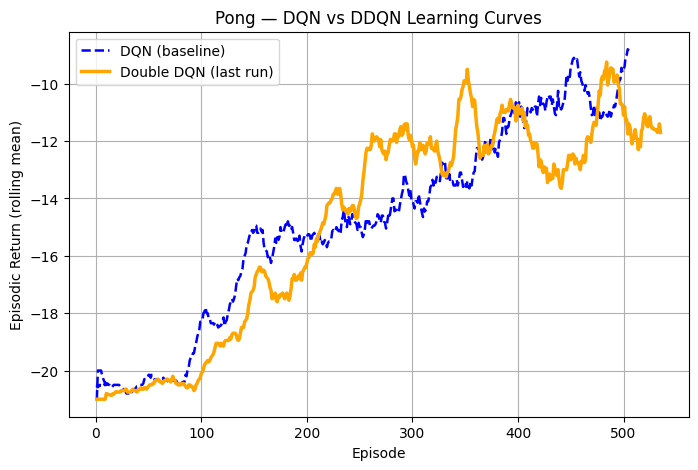

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

base_csv = Path("runs/baseline_pong/training_log.csv")
ddqn_csv = Path("runs/ddqn_pong/training_log.csv")

have_base = base_csv.exists()
have_ddqn = ddqn_csv.exists()

if not have_base and not have_ddqn:
    raise FileNotFoundError("No logs found. Run baseline/DDQN training first.")

window = 20  # smoothing window
plt.figure(figsize=(8,5))

# ---- Baseline ----
if have_base:
    baseline_df = pd.read_csv(base_csv)
    baseline_df["rolling_return"] = baseline_df["episode_return"].rolling(window, min_periods=1).mean()
    plt.plot(
        baseline_df["episode"],
        baseline_df["rolling_return"],
        label="DQN (baseline)",
        color="blue",
        linestyle="--",
        linewidth=1.8,
    )

# ---- DDQN: keep only the *last* run in the CSV ----
if have_ddqn:
    ddqn_df = pd.read_csv(ddqn_csv)

    # detect restarts: when episode number drops, that's a new run
    ddqn_df["ep_diff"] = ddqn_df["episode"].diff()
    restarts = ddqn_df[ddqn_df["ep_diff"] < 0].index.tolist()
    last_start = restarts[-1] if len(restarts) > 0 else 0
    ddqn_last = ddqn_df.iloc[last_start:].copy()

    ddqn_last["rolling_return"] = ddqn_last["episode_return"].rolling(window, min_periods=1).mean()

    plt.plot(
        ddqn_last["episode"],
        ddqn_last["rolling_return"],
        label="Double DQN (last run)",
        color="orange",
        linewidth=2.5,
    )

title_bits = []
if have_base: title_bits.append("DQN")
if have_ddqn: title_bits.append("DDQN")
plt.title(f"Pong — {' vs '.join(title_bits)} Learning Curves")
plt.xlabel("Episode")
plt.ylabel("Episodic Return (rolling mean)")
plt.grid(True)
plt.legend()
plt.show()


**EARLY video (random agent)**

In [ ]:
# EARLY VIDEO (random agent, no policy)
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
from pathlib import Path

VIDEO_DIR = Path("videos")
VIDEO_DIR.mkdir(exist_ok=True)

env = gym.make("ALE/Pong-v5", render_mode="rgb_array")
env = RecordVideo(env, video_folder=str(VIDEO_DIR), name_prefix="pong_early")

obs, info = env.reset()
done = False
truncated = False

# Run ~1000 frames (~10 seconds)
for _ in range(1000):
    action = env.action_space.sample()   # random action
    obs, reward, done, truncated, info = env.step(action)
    if done or truncated:
        break

env.close()
print("Saved early video to:", VIDEO_DIR)


/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Saved early video to: videos


**LATE / LEARNED video (My trained model)**

In [ ]:
import os

for root, dirs, files in os.walk("/content/drive", topdown=True):
    for f in files:
        if f.endswith(".dat"):
            print(os.path.join(root, f))


/content/drive/MyDrive/PUBLIC/Models/ALE_Pong-v5-best_-21-20251121-1642-test_epsdec10000_rs1000_sync500.dat
/content/drive/MyDrive/PUBLIC/Models/ALE_Pong-v5-best_-21-20251121-1644-test_epsdec10000_rs1000_sync500.dat
/content/drive/MyDrive/PUBLIC/Models/ALE_Pong-v5-best_-20-20251121-1647-test_epsdec10000_rs1000_sync500.dat
/content/drive/MyDrive/PUBLIC/Models/ALE_Pong-v5-best_-19-20251121-1651-test_epsdec10000_rs1000_sync500.dat
/content/drive/MyDrive/PUBLIC/Models/ALE_Pong-v5-best_-19-20251121-1652-test_epsdec10000_rs1000_sync500.dat
/content/drive/MyDrive/PUBLIC/Models/ALE_Pong-v5-best_-18-20251121-1653-test_epsdec10000_rs1000_sync500.dat
/content/drive/MyDrive/PUBLIC/Models/ALE_Pong-v5-best_-18-20251121-1654-test_epsdec10000_rs1000_sync500.dat
/content/drive/MyDrive/PUBLIC/Models/ALE_Pong-v5-best_-17-20251121-1655-test_epsdec10000_rs1000_sync500.dat
/content/drive/MyDrive/PUBLIC/Models/ALE_Pong-v5-best_-17-20251121-1656-test_epsdec10000_rs1000_sync500.dat
/content/drive/MyDrive/PUBLI

In [ ]:
# LATE VIDEO (learned agent, simple version using trained model)
import gymnasium as gym
import ale_py                       # makes ALE/Pong-v5 available
from gymnasium.wrappers import RecordVideo
from pathlib import Path
import torch
import numpy as np
import collections
import typing as tt

!pip install stable-baselines3
from stable_baselines3.common import atari_wrappers  # ❤ important
from gymnasium import spaces
import torch.nn as nn

# Redefine ImageToPyTorch and BufferWrapper to make this cell self-contained
class ImageToPyTorch(gym.ObservationWrapper):
    """
    ImageToPyTorch: Reorders image dimensions from (H, W, C) to (C, H, W)
    for compatibility with PyTorch convolutional layers.
    """
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        obs = self.observation_space
        assert isinstance(obs, gym.spaces.Box)
        assert len(obs.shape) == 3
        new_shape = (obs.shape[-1], obs.shape[0], obs.shape[1])
        self.observation_space = gym.spaces.Box(
            low=obs.low.min(), high=obs.high.max(),
            shape=new_shape, dtype=obs.dtype)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)


class BufferWrapper(gym.ObservationWrapper):
    """
    BufferWrapper: Maintains a rolling window of the last `n_steps` frames
    to give the agent a sense of temporal context.
    """
    def __init__(self, env, n_steps):
        super(BufferWrapper, self).__init__(env)
        obs = env.observation_space
        assert isinstance(obs, spaces.Box)
        new_obs = gym.spaces.Box(
            obs.low.repeat(n_steps, axis=0), obs.high.repeat(n_steps, axis=0),
            dtype=obs.dtype)
        self.observation_space = new_obs
        self.buffer = collections.deque(maxlen=n_steps)

    def reset(self, *, seed: tt.Optional[int] = None, options: tt.Optional[dict[str, tt.Any]] = None):
        for _ in range(self.buffer.maxlen):
            self.buffer.append(np.zeros_like(self.env.observation_space.low))
        obs, extra = self.env.reset()
        return self.observation(obs), extra

    def observation(self, observation: np.ndarray) -> np.ndarray:
        self.buffer.append(observation)
        return np.concatenate(self.buffer)


#dqn_model class (copied from earlier cell to make this cell self-contained)
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
        )
        size = self.conv(torch.zeros(1, *input_shape)).size()[-1]
        self.fc = nn.Sequential(
            nn.Linear(size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )
    def forward(self, x: torch.ByteTensor):
        x = x.float() / 255.0
        return self.fc(self.conv(x))

VIDEO_DIR = Path("videos")
VIDEO_DIR.mkdir(exist_ok=True)

# -------- 1. AUTO-FIND model in Google Drive --------
MODELS_DIR = Path("/content/drive/MyDrive/PUBLIC/Models")

if not MODELS_DIR.exists():
    raise FileNotFoundError("Your model folder was not found: /content/drive/MyDrive/PUBLIC/Models")

# Get all .dat model files
model_files = sorted(
    [p for p in MODELS_DIR.glob("*.dat")],
    key=lambda p: p.stat().st_mtime
)

if not model_files:
    raise FileNotFoundError("No .dat files found in Google Drive model folder.")

model_path = model_files[-1]   # most recent .dat file
print("Using model file:", model_path)

# -------- 2. Build environment (same as training) --------
env = gym.make("ALE/Pong-v5", render_mode="rgb_array")
env = atari_wrappers.AtariWrapper(env, clip_reward=False, noop_max=0)
env = ImageToPyTorch(env)
env = BufferWrapper(env, n_steps=4)

# Wrap for video recording (like early video)
env = RecordVideo(env, video_folder=str(VIDEO_DIR), name_prefix="pong_late")

# -------- 3. Load model --------
net = DQN(env.observation_space.shape, env.action_space.n)
net.load_state_dict(torch.load(model_path, map_location="cpu"))
net.eval()

obs, info = env.reset()
done = False
truncated = False

# -------- 4. Play 1000 frames with learned policy --------
with torch.no_grad():
    for _ in range(1000):
        state_v = torch.as_tensor(obs).unsqueeze(0)
        qvals = net(state_v)
        action = int(qvals.argmax().item())

        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            break

env.close()
print("Saved late video to:", VIDEO_DIR)

Using model file: /content/drive/MyDrive/PUBLIC/Models/ALE_Pong-v5-DDQN-best_-11-20251127-0039-DDQN_epsdec10000_rs1000_sync500.dat
Saved late video to: videos


# ***Reflection***

I chose Pong because it is a classic benchmark for Deep Q-Learning and gives clear, easy-to-interpret behavior as the agent improves. The game uses sparse and delayed rewards, which makes it a good test of whether a model can learn from longer sequences of actions without constant feedback. Early in training, the agent acted randomly and lost points quickly. Over time, both DQN and Double DQN started tracking the ball better and positioning the paddle correctly, showing clear improvements in timing and control.

The baseline DQN model showed unstable and slow learning. Its rolling-return curve improved from about –21 to around –15 but had a lot of noise and fluctuations. This happened because standard DQN tends to overestimate Q-values and struggles with delayed rewards. In contrast, Double DQN learned faster and more consistently, reaching around –11 with smoother improvements. This matched expectations, since Double DQN reduces overestimation by separating action selection and action evaluation. Watching the late-stage gameplay made the difference clear: the DDQN agent reacted more reliably and recovered better when out of position.

If I continued this project, I would try additional improvements such as Prioritized Experience Replay or N-step returns to help with sparse rewards. I would also tune hyperparameters like the epsilon schedule and target network update rate, since they likely affected the performance differences between the runs. Overall, this project helped me better understand the stability challenges in value-based deep reinforcement learning and how small algorithm changes can noticeably improve learning.